# Sesión 05 - Arquitecturas Avanzadas: NLP

En esta sesión número 5 pondremos en práctica lo estudiado en el fastbook, abordando un problema de análisis de sentimientos sobre un dataset de twitter. Primero analizaremos el dataset haciendo un pequeño análisis exploratorio de los datos. Después veremos qué tipo de preprocesamiento le aplicamos a los textos. A continuación representaremos los tweets como vectores numéricos para que sirvan como input de los modelos (word embeddings). Finalmente, entrenaremos un clasificador de sentimientos utilizando una red neuronal feedforward, un tipo de red neuronal recurrente (LSTM) y un modelo preentrenado (BERT) y compararemos los resultados.

# Índice
0. Instalación de librerías
1. Carga de datos
2. Análisis exploratorio
3. Preprocesamiento
4. Wordclouds
5. Word embeddings
6. Análisis de sentimientos
7. Comparación de modelos

## 0. Instalar librerías

In [1]:
!pip install -q opendatasets
!pip install pandas
!pip install matplotlib
!pip install seaborn
!pip install spacy
!pip install nltk
!pip install wordcloud
!pip install gensim
!pip install scikit-learn
!pip install tensorflow
!pip install keras
!pip install transformers
!pip install scipy==1.10.1
!pip install tf-keras
!pip install torch 
!pip install datasets
!pip install accelerate -U
!python -m spacy download en_core_web_sm
!pip freeze > requirments.txt

   ---------------------------------------- 0.0/13.9 MB ? eta -:--:--
   ---------------------------------------- 0.0/13.9 MB ? eta -:--:--
   - -------------------------------------- 0.5/13.9 MB 1.9 MB/s eta 0:00:08
   --- ------------------------------------ 1.0/13.9 MB 2.8 MB/s eta 0:00:05
   ------ --------------------------------- 2.1/13.9 MB 3.3 MB/s eta 0:00:04
   ------- -------------------------------- 2.6/13.9 MB 3.4 MB/s eta 0:00:04
   --------- ------------------------------ 3.4/13.9 MB 3.2 MB/s eta 0:00:04
   ------------ --------------------------- 4.2/13.9 MB 3.4 MB/s eta 0:00:03
   --------------- ------------------------ 5.2/13.9 MB 3.5 MB/s eta 0:00:03
   ----------------- ---------------------- 6.0/13.9 MB 3.6 MB/s eta 0:00:03
   ------------------- -------------------- 6.8/13.9 MB 3.6 MB/s eta 0:00:02
   --------------------- ------------------ 7.6/13.9 MB 3.6 MB/s eta 0:00:02
   ------------------------ --------------- 8.4/13.9 MB 3.7 MB/s eta 0:00:02
   ----------

ERROR: Ignored the following yanked versions: 1.11.0, 1.14.0rc1
ERROR: Ignored the following versions that require a different python version: 1.10.0 Requires-Python >=3.8,<3.12; 1.10.0rc1 Requires-Python >=3.8,<3.12; 1.10.0rc2 Requires-Python >=3.8,<3.12; 1.10.1 Requires-Python >=3.8,<3.12; 1.6.2 Requires-Python >=3.7,<3.10; 1.6.3 Requires-Python >=3.7,<3.10; 1.7.0 Requires-Python >=3.7,<3.10; 1.7.1 Requires-Python >=3.7,<3.10; 1.7.2 Requires-Python >=3.7,<3.11; 1.7.3 Requires-Python >=3.7,<3.11; 1.8.0 Requires-Python >=3.8,<3.11; 1.8.0rc1 Requires-Python >=3.8,<3.11; 1.8.0rc2 Requires-Python >=3.8,<3.11; 1.8.0rc3 Requires-Python >=3.8,<3.11; 1.8.0rc4 Requires-Python >=3.8,<3.11; 1.8.1 Requires-Python >=3.8,<3.11; 1.9.0 Requires-Python >=3.8,<3.12; 1.9.0rc1 Requires-Python >=3.8,<3.12; 1.9.0rc2 Requires-Python >=3.8,<3.12; 1.9.0rc3 Requires-Python >=3.8,<3.12; 1.9.1 Requires-Python >=3.8,<3.12
ERROR: Could not find a version that satisfies the requirement scipy==1.10.1 (from versions:

   ---------------------------------------- 0.0/1.7 MB ? eta -:--:--
   ---------------------------------------- 0.0/1.7 MB ? eta -:--:--
   ------------------ --------------------- 0.8/1.7 MB 3.7 MB/s eta 0:00:01
   ---------------------------------------- 1.7/1.7 MB 3.8 MB/s  0:00:00
   ---------------------------------------- 0.0/28.0 MB ? eta -:--:--
    --------------------------------------- 0.5/28.0 MB 3.4 MB/s eta 0:00:09
   - -------------------------------------- 1.3/28.0 MB 3.5 MB/s eta 0:00:08
   -- ------------------------------------- 2.1/28.0 MB 3.6 MB/s eta 0:00:08
   ---- ----------------------------------- 2.9/28.0 MB 3.5 MB/s eta 0:00:08
   ----- ---------------------------------- 3.7/28.0 MB 3.7 MB/s eta 0:00:07
   ------ --------------------------------- 4.5/28.0 MB 3.7 MB/s eta 0:00:07
   ------- -------------------------------- 5.2/28.0 MB 3.7 MB/s eta 0:00:07
   -------- ------------------------------- 6.0/28.0 MB 3.7 MB/s eta 0:00:07
   --------- --------------

In [3]:
import opendatasets as od
import pandas as pd
pd.set_option('display.max_colwidth', None)
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import spacy 
import nltk
from nltk.corpus import stopwords
from wordcloud import WordCloud
import re
import gensim.downloader
from gensim.models import Word2Vec
from gensim.parsing.preprocessing import preprocess_string
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Input, Dense, Dropout, Embedding, Flatten
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.layers import LSTM
from transformers import BertTokenizer, TFBertForSequenceClassification, pipeline, TFBertModel, AutoModelForSequenceClassification, TFAutoModelForSequenceClassification, AutoTokenizer, AutoConfig
from sklearn.model_selection import train_test_split
from scipy.special import softmax

# Load the spaCy English model
nlp = spacy.load("en_core_web_sm")
nltk.download('vader_lexicon')
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('punkt')

import warnings
warnings.filterwarnings("ignore")
warnings.simplefilter(action='ignore', category=FutureWarning)

[nltk_data] Downloading package vader_lexicon to
[nltk_data]     C:\Users\juanq\AppData\Roaming\nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\juanq\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\juanq\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\juanq\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


## 1. Cargamos el dataset de Análisis de Sentimientos de Twitter

Se trata de un conjunto de datos de análisis de sentimiento de tweets de Twitter. Dado un mensaje, la tarea consiste en juzgar el sentimiento del mensaje. Hay tres clases en este conjunto de datos: Positivo, Negativo y Neutral. Los mensajes que no son relevantes para la entidad (es decir, irrelevantes) se consideran neutrales.

Link: https://www.kaggle.com/datasets/jp797498e/twitter-entity-sentiment-analysis/data


In [ ]:
# Definimos los nombres de las columnas
columns=['id','category','label','text']

# Descargarmos los datasets y los leemos
od.download('https://www.kaggle.com/datasets/jp797498e/twitter-entity-sentiment-analysis') # inserta tu usuario y key de kaggle
df_train = pd.read_csv('./twitter-entity-sentiment-analysis/twitter_training.csv', names=columns)
df_test = pd.read_csv('./twitter-entity-sentiment-analysis/twitter_validation.csv', names=columns)

Please provide your Kaggle credentials to download this dataset. Learn more: http://bit.ly/kaggle-creds
Your Kaggle username:

In [ ]:
# Mostramos 5 registros aleatorios
df_train.sample(10)

,id,category,label,text
36290,8228,Microsoft,Neutral,"Bleepin: Fast forward to 2020, and Microsoft has released a security update to fix a mysterious ""flaw"" in Windows called CVE-2020-1464. No mention is made of who discovered the vulnerability on their official page.. portal.rc.micross.com / en-US / security..."
37026,8351,Microsoft,Positive,these apps have been so useful recently and my life have never been so convenient;. . Merriam Webster Dictionary. Bank Mobile Apps. PayMaya. Microsoft Excel
23723,4465,Google,Positive,"It's been a few days since the announcement of you Google Pixel 4a, it includes the headphone jack. A freakin' fucking jack... Months ago, I gave up on any mobile phone working for Premiere not having it and now sit around a bunch tiny adapters. https://t.co/0i4376XSvj]"
64538,7856,MaddenNFL,Negative,@ EASPORTS _ MUT @ EAMaddenNFL @ EASPORTS sooooo for a week now I'd like to switch my skills to defense because it means so much that you play from defense...
22007,4166,CS-GO,Irrelevant,Happy bday to my fav dvd file player please have a wonderful one love ya homie.
46620,12000,Verizon,Negative,"@verizonmedia @Verizon how long are you going to deny me a refund for merch returned to your warehouse in January? I’ve spent hours on the phone with different reps, why is a refund for merchandise I NEVER RECEIVED so difficult to obtain? Are you really going to steal my $115?"
48800,5977,HomeDepot,Irrelevant,"Hey, I don't even feel safe in my own neighborhood."
27351,1107,AssassinsCreed,Positive,my ass still knee-deep in Assassins Creed Odyssey with no way out to soon lmao
45182,11758,Verizon,Positive,Bruh the Verizon env3 was uninitiated i miss it pic.facebook.com / xXePl2gr3K
56775,11341,TomClancysRainbowSix,Negative,Full cheater stack NA RhandlerR RhandlerR fix your fucking anticheat pic.twitter.com/0BQL128YRI


In [ ]:
# Mostramos el número de filas y columnas
print(f"El dataset de entrenamiento tiene {df_train.shape[0]} filas y el de test tiene {df_test.shape[0]} filas")

El dataset de entrenamiento tiene 74682 filas y el de test tiene 1000 filas


## 2. Análisis exploratorio de datos

En este apartado se realizará un análisis exploratorio de los datos. Se mostrará la distribución de las clases por categoría y veremos las nubes de palabras para cada clase.

/tmp/ipykernel_2656450/4085805419.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(df_train.label, palette='viridis', order = df_train['label'].value_counts().index)


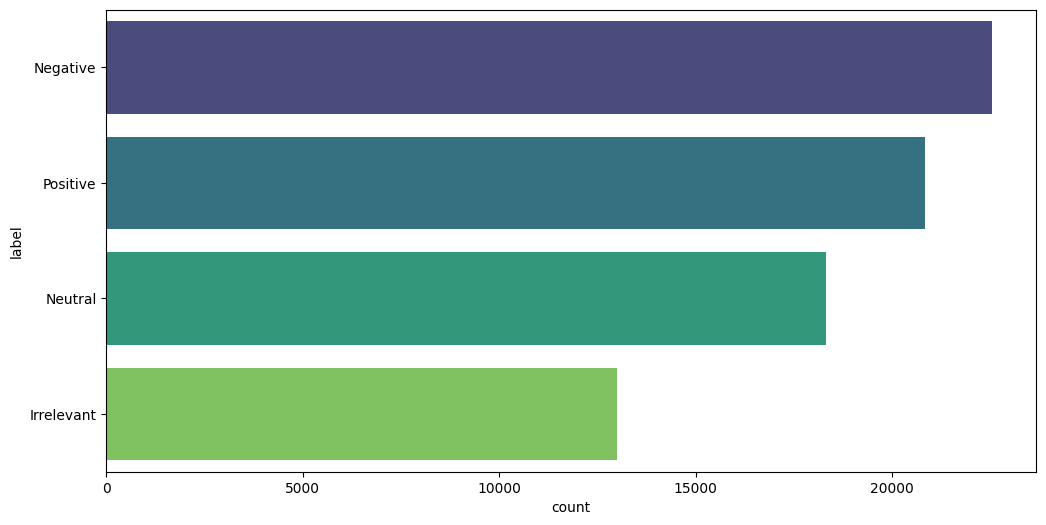

/tmp/ipykernel_2656450/4085805419.py:8: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(df_train.category, palette='viridis', order = df_train['category'].value_counts().index)


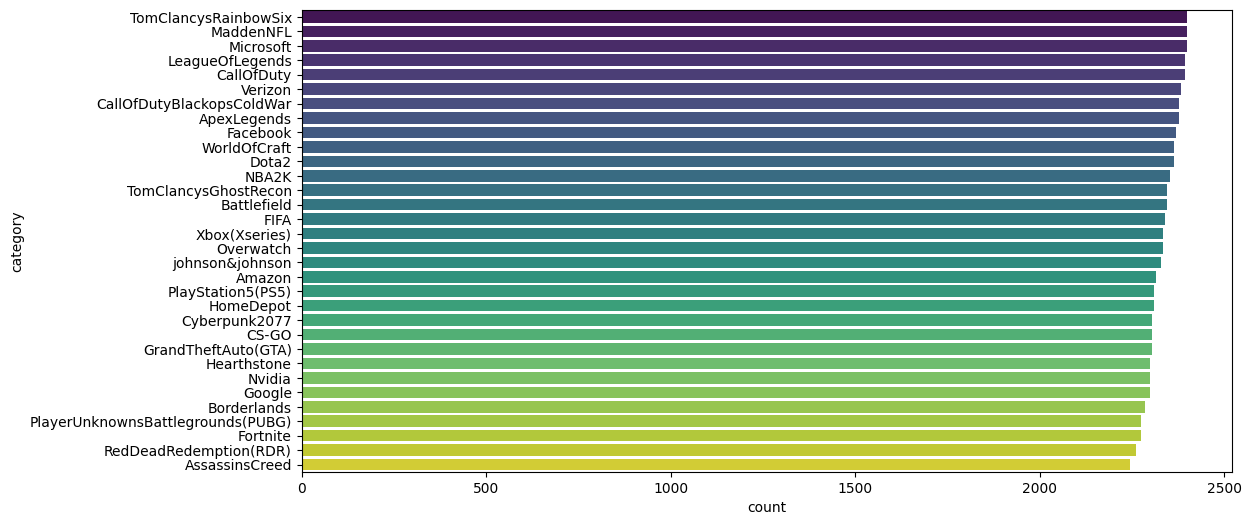

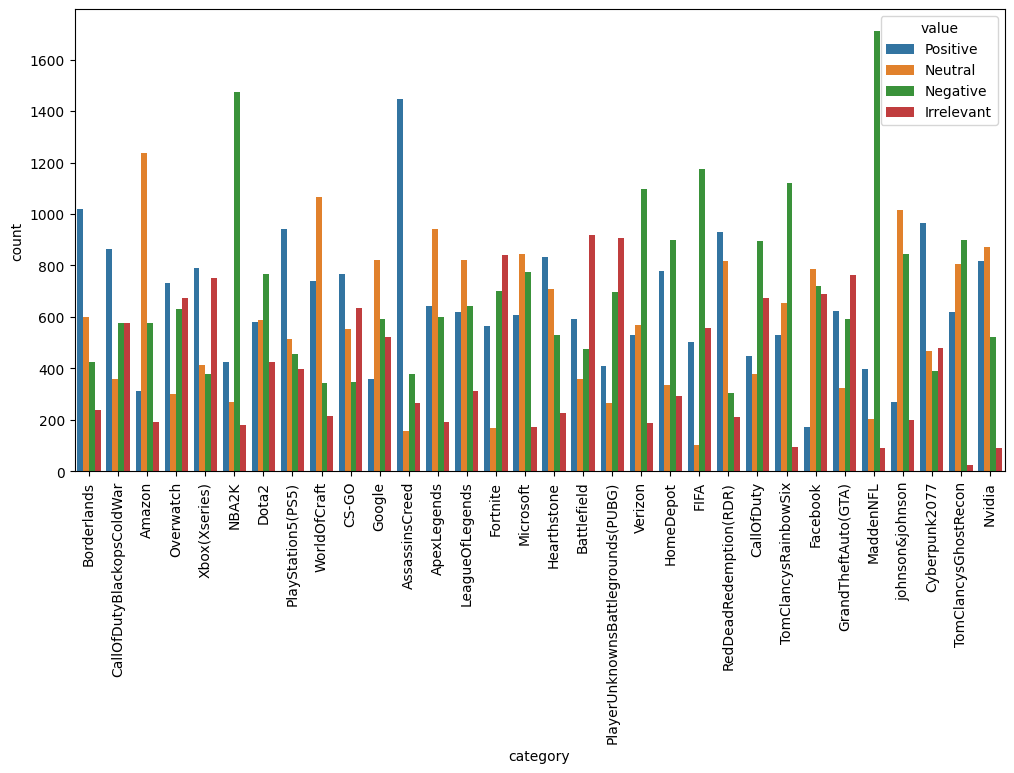

In [ ]:
# Mostramos la distribución de las etiquetas
plt.figure(figsize=(12,6))
sns.countplot(df_train.label, palette='viridis', order = df_train['label'].value_counts().index)
plt.show()

# Mostramos la distribución de las categorías
plt.figure(figsize=(12,6))
sns.countplot(df_train.category, palette='viridis', order = df_train['category'].value_counts().index)
plt.show()

# Mostramos la distribución de las etiquetas en cada categoría
plt.figure(figsize=(12,6))
sns.countplot(data=pd.melt(df_train, id_vars=['category'], value_vars=['label'], var_name='label'), x='category', hue='value')
plt.xticks(rotation=90)  # Add this line to rotate x-axis labels to vertical
plt.show()

## 3. Preprocesamiento de los datos

Antes de vectorizar los textos y entrenar los modelos, es necesario realizar un preprocesamiento de los datos. En este apartado se realizará la limpieza de los textos, eliminando caracteres especiales, números, stopwords, etc.

In [ ]:
def limpiar_tweet(tweet):
    # Convertir a string
    tweet = str(tweet)

    # Eliminar URLs
    tweet = re.sub(r'http\S+', '', tweet)

    # Eliminar menciones y hashtags
    tweet = re.sub(r'@[A-Za-z0-9_]+|#[A-Za-z0-9_]+', '', tweet)

    # Eliminar caracteres especiales, números, and signos de puntuación
    tweet = re.sub(r'[^A-Za-z\s]', '', tweet)

    # Eliminar indicador de 'RT' (Retweet)
    tweet = re.sub(r'\bRT\b', '', tweet)

    # Reemplazamos contracciones
    tweet = re.sub(r"won\'t", "would not", tweet)
    tweet = re.sub(r"im", "i am", tweet)
    tweet = re.sub(r"Im", "I am", tweet)
    tweet = re.sub(r"can\'t", "can not", tweet)
    tweet = re.sub(r"don\'t", "do not", tweet)
    tweet = re.sub(r"shouldn\'t", "should not", tweet)
    tweet = re.sub(r"needn\'t", "need not", tweet)
    tweet = re.sub(r"hasn\'t", "has not", tweet)
    tweet = re.sub(r"haven\'t", "have not", tweet)
    tweet = re.sub(r"weren\'t", "were not", tweet)
    tweet = re.sub(r"mightn\'t", "might not", tweet)
    tweet = re.sub(r"didn\'t", "did not", tweet)
    tweet = re.sub(r"n\'t", " not", tweet)
    tweet = re.sub(r"\'re", " are", tweet)
    tweet = re.sub(r"\'s", " is", tweet)
    tweet = re.sub(r"\'d", " would", tweet)
    tweet = re.sub(r"\'ll", " will", tweet)
    tweet = re.sub(r"\'t", " not",tweet)
    tweet = re.sub(r"\'ve", " have", tweet)
    tweet = re.sub(r"\'m", " am", tweet)

    # Eliminar caracteres especiales
    tweet = re.sub(r'[!]+' , '!' , tweet)
    tweet = re.sub(r'[?]+' , '?' , tweet)
    tweet = re.sub(r'[.]+' , '.' , tweet)
    tweet = re.sub(r'[@]+' , '@' , tweet)
    tweet = re.sub(r'unk' , ' ' , tweet)
    tweet = re.sub('\n', '', tweet)

    # Convertir a minúsculas y eliminar espacios extra
    tweet = tweet.lower()
    tweet = re.sub(r'[ ]+' , ' ' , tweet)

    # Eliminar stopwords
    stop_words = set(stopwords.words('english'))
    tweet_tokens = nltk.word_tokenize(tweet)
    tweet = ' '.join([word for word in tweet_tokens if word not in stop_words])

    # # Lematización
    # doc = nlp(tweet)
    # # Lematizar cada token y juntarlos de nuevo en un string
    # tweet = ' '.join([token.lemma_ for token in doc])

    return tweet

In [ ]:
# Plot some stopwords
stopwords.words('english')[:10]

['i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're"]

In [ ]:
# Aplicamos el preprocesamiento a los tweets
df_train['text_clean'] = df_train['text'].apply(limpiar_tweet)
df_test['text_clean'] = df_test['text'].apply(limpiar_tweet)

In [ ]:
df_train.sample(5)

,id,category,label,text,text_clean
39313,5548,Hearthstone,Neutral,Popular on YouTube: RATTLEGORE IS UNKILLA... oh wait... oh God... oh no... | Scholomance Academy | Hearthstone youtube.com / watch? v = u0WnlJ...,popular youtube rattlegore unkilla oh wait oh god oh scholomance academy hearthstone youtubecom watch v uwnlj
22106,4183,CS-GO,Irrelevant,s1pple goat,spple goat
18717,12408,WorldOfCraft,Neutral,Please come join me live at twitch.tv/per0tin as I do some mount farming in WoW! .,please come join live twitchtvpertin mount farming wow
45202,11761,Verizon,Negative,Team Verizon is having a bad Monday pic.twitter.com/ctSTk6qZt0,team verizon bad monday pictwittercomctstkqzt
46524,11984,Verizon,Positive,This is so wonderful!,wonderful


In [ ]:
df_train.to_csv('df_train_clean.csv', index=False)
df_test.to_csv('df_test_clean.csv', index=False)

In [ ]:
# Leer dataset limpios para evitar volver a ejecutar el preprocesamiento
df_train = pd.read_csv('./df_train_clean.csv')
df_test = pd.read_csv('./df_test_clean.csv')

In [ ]:
# Print number of rows with empty values in any column
print(f"El dataset de entrenamiento tiene {df_train.isnull().any(axis=1).sum()} filas con valores nulos")
print(f"El dataset de test tiene {df_test.isnull().any(axis=1).sum()} filas con valores nulos")

# Eliminamos filas vacías
df_train = df_train.dropna()
df_test = df_test.dropna()

El dataset de entrenamiento tiene 2605 filas con valores nulos
El dataset de test tiene 1 filas con valores nulos


## 4. Wordclouds

Aquí se mostrarán las nubes de palabras para cada clase: positiva, negativa, neutral e irrelevante.

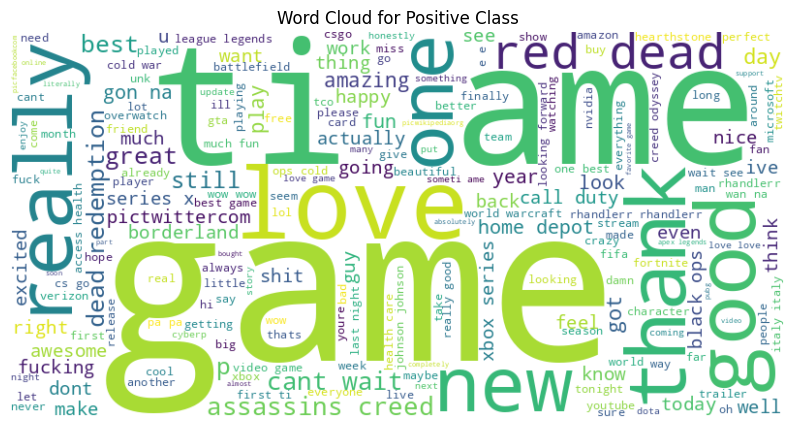

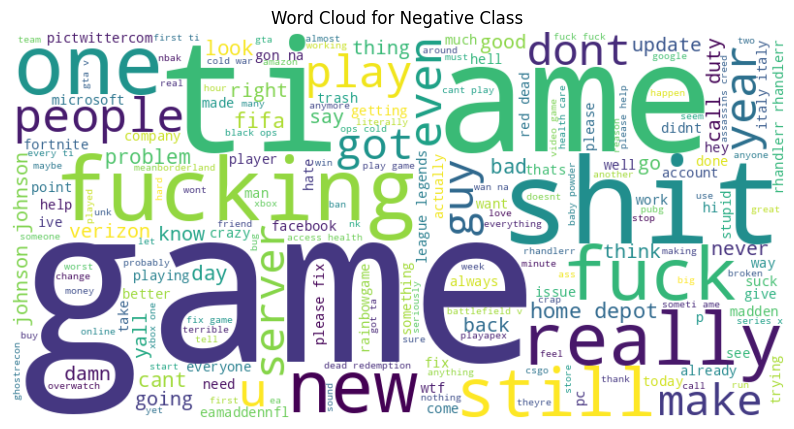

In [ ]:
# Generate word clouds for each class
for label in ['Positive','Negative']:
    # Filter the data for the current class
    data = df_train[df_train['label'] == label]['text_clean']
    
    # Concatenate all the text data into a single string
    text = ' '.join(data)
    
    # Create a word cloud object
    wordcloud = WordCloud(width=800, height=400, background_color='white').generate(text)
    
    # Plot the word cloud
    plt.figure(figsize=(10, 6))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.title(f'Word Cloud for {label} Class')
    plt.axis('off')
    plt.show()

Vemos como para el sentimiento positivo hay palabras como 'good', 'great' o 'love. Para el negativo en cambio hay palabras como 'fuck', 'shit' o 'bad'

## 5. Word Embeddings

Como vimos en el fastbook, debemos encontrar la manera de representar los textos como vectores numéricos para que sean entendidas por la máquinas y así nos sirvan como entrada a los modelos. Usaremos dos técnicas básicas: TF-IDF y word2vec.

### 5.1 Bag of Words

Bag of words es una forma de representar textos basados en la frecuencia en la que aparecen en el corpus. Primero ponemos un ejemplo simple y luego lo hacemos con los tweets preprocesados.

In [ ]:
corpus = [
    'This is the first document.',
    'This document is the second document.',
    'And this is the third one.',
    'Is this the first document?',
]
vectorizer = CountVectorizer()
X = vectorizer.fit_transform(corpus)
print(f'El vocabulario es el siguiente: \n{vectorizer.get_feature_names_out()}\n')
print(f'El corpus queda representado de la siguiente manera: \n{X.toarray()}')

El vocabulario es el siguiente: 
['and' 'document' 'first' 'is' 'one' 'second' 'the' 'third' 'this']

El corpus queda representado de la siguiente manera: 
[[0 1 1 1 0 0 1 0 1]
 [0 2 0 1 0 1 1 0 1]
 [1 0 0 1 1 0 1 1 1]
 [0 1 1 1 0 0 1 0 1]]


In [ ]:
# Create an instance of CountVectorizer
count_vectorizer = CountVectorizer()

# Fit and transform the 'text_clean' column
bow_encoded = count_vectorizer.fit_transform(df_train['text_clean'])

# Print an example
print(f"El tweet '{df_train.text_clean[50]}' se codifica como:\n{bow_encoded[50]}")

El tweet 'guilty sobriety bit borderline called work early tomorrow cant catch' se codifica como:
  (0, 3978)	1
  (0, 18444)	1
  (0, 31346)	1
  (0, 1010)	1
  (0, 13034)	1
  (0, 31623)	1
  (0, 4859)	1
  (0, 3606)	1
  (0, 28261)	1
  (0, 30457)	1
  (0, 17787)	1
  (0, 3419)	1
  (0, 4729)	1
  (0, 9289)	1
  (0, 35043)	1
  (0, 28968)	1
  (0, 18099)	1
  (0, 32540)	1


### 5.2 TF-IDF

En este apartado representaremos los textos con TF-IDF. Sabemos que es un tipo de representación que cuenta la frecuencia de las palabras en un corpus. La idea detrás de TF-IDF es identificar la relevancia de una palabra no solo por su frecuencia en un documento individual (TF), sino también por la rareza de la palabra en todo el corpus (IDF). 

In [ ]:
corpus = [
    'This is the first document.',
    'This document is the second document.',
    'And this is the third one.',
    'Is this the first document?',
]
tfidf_vectorizer = TfidfVectorizer()
X = tfidf_vectorizer.fit_transform(corpus)
print(f'El vocabulario es el siguiente: \n{tfidf_vectorizer.get_feature_names_out()}\n')
print(f'El corpus queda representado de la siguiente manera: \n{X.toarray()}')

El vocabulario es el siguiente: 
['and' 'document' 'first' 'is' 'one' 'second' 'the' 'third' 'this']

El corpus queda representado de la siguiente manera: 
[[0.         0.46979139 0.58028582 0.38408524 0.         0.
  0.38408524 0.         0.38408524]
 [0.         0.6876236  0.         0.28108867 0.         0.53864762
  0.28108867 0.         0.28108867]
 [0.51184851 0.         0.         0.26710379 0.51184851 0.
  0.26710379 0.51184851 0.26710379]
 [0.         0.46979139 0.58028582 0.38408524 0.         0.
  0.38408524 0.         0.38408524]]


In [ ]:
# Create an instance of TfidfVectorizer
tfidf_vectorizer = TfidfVectorizer()

# Fit and transform the 'text_clean' column
tfidf_encoded = tfidf_vectorizer.fit_transform(df_train['text_clean'])

# Print an example
print(f'El tweet "{df_train.text_clean[10]}" se codifica como:\n{tfidf_encoded[10]}')

El tweet "spent hours making something fun dont know huge rhandlerr fan maya one favorite characters decided make wallpaper pc original amage versus creation made enjoy pictwittercommlsiwfjg" se codifica como:
  (0, 26464)	0.1533991062442987
  (0, 23253)	0.317098610464768
  (0, 9818)	0.1780289954712613
  (0, 18354)	0.1546209706041934
  (0, 6949)	0.29674563907122703
  (0, 33707)	0.27134660608889705
  (0, 858)	0.231029584628634
  (0, 21732)	0.19864067453744275
  (0, 22397)	0.16511064832568104
  (0, 34168)	0.2782877207217355
  (0, 18444)	0.14106054690835065
  (0, 7732)	0.19929759524487167
  (0, 5329)	0.19877088819162114
  (0, 10762)	0.17116933201657847
  (0, 21482)	0.1192366604412724
  (0, 18787)	0.26328828106564683
  (0, 10650)	0.18870516664358272
  (0, 14634)	0.1808662618957447
  (0, 16937)	0.13975530398538905
  (0, 8807)	0.1280543231884273
  (0, 11979)	0.14279272088508
  (0, 28907)	0.1572921868355643
  (0, 18453)	0.16905525671149593
  (0, 14528)	0.17220700645932263
  (0, 29147)	0.20373

### 5.3 Word2vec y GloVe

En este apartado entrenaremos desde cero un modelo de embeddings Word2vec y analizaremos la similitud entre varias palabras de ejemplo. Sabemos que word2vec sí tiene en cuenta el contexto de las palabras, lo que genera representaciones más ricas.

In [ ]:
# Preprocess texts: tokenize and clean
texts = df_train['text_clean'].apply(preprocess_string).tolist()

# Train Word2Vec model
model_w2v = Word2Vec(sentences=texts, vector_size=100, window=5, min_count=1, workers=1)
model_w2v.save("word2vec.model")

In [ ]:
# Example of measuring similarity
word_vectors = model_w2v.wv
similarity = word_vectors.similarity('clear', 'light')
print(f"Similitud entre 'clear' and 'light': {similarity}\n")

similarity = word_vectors.similarity('good', 'great')
print(f"Similitud entre 'good' and 'great': {similarity}\n")

similarity = word_vectors.similarity('fuck', 'shit')
print(f"Similitud entre 'fuck' and 'shit': {similarity}\n")

similarity = word_vectors.similarity('hate', 'love')
print(f"Similitud entre 'hate' and 'love': {similarity}")

Similitud entre 'clear' and 'light': 0.9427515864372253

Similitud entre 'good' and 'great': 0.8101799488067627

Similitud entre 'fuck' and 'shit': 0.925658643245697

Similitud entre 'hate' and 'love': 0.48194053769111633


In [ ]:
# Find the 5 most similar words to 'hate'
try:
    similar_words = model_w2v.wv.most_similar('hate', topn=10)
    print("10 palabras más similares a 'hate':")
    for word, similarity in similar_words:
        print(f"{word}: {similarity}")
except KeyError:
    print("'hate' is not in the vocabulary.")

10 palabras más similares a 'hate':
yell: 0.9154349565505981
rude: 0.9057527780532837
laredo: 0.9041017293930054
die: 0.9008967876434326
glfor: 0.9001948833465576
shooti: 0.8957918286323547
told: 0.8950859308242798
shoulder: 0.8933627605438232
lakh: 0.8920971751213074
mf: 0.8916411995887756


In [ ]:
# Find the 5 most similar words to 'xbox'
try:
    similar_words = model_w2v.wv.most_similar('xbox', topn=10)
    print("10 palabras más similares a 'xbox':")
    for word, similarity in similar_words:
        print(f"{word}: {similarity}")
except KeyError:
    print("'xbox' is not in the vocabulary.")

10 palabras más similares a 'xbox':
rainbowsix: 0.877592921257019
diari: 0.8566380143165588
playstat: 0.8423289060592651
ggwp: 0.8326742649078369
lcslec: 0.8142217397689819
lunat: 0.8068251609802246
incomplet: 0.8013732433319092
forcibl: 0.7975358366966248
lec: 0.7969276905059814
isgdwoebh: 0.7912021279335022


#### 5.3.1 Usando modelo preentrenado de GloVe

La librería Gensim tiene modelos preentrenados de Word2vec y Glove. En este apartado usaremos un modelo preentrenado de GloVe para representar los textos como vectores numéricos. El modelo se ha entrenado con datos de Twitter.

Link: https://radimrehurek.com/gensim/models/word2vec.html

In [ ]:
# Download the "glove-twitter-25" embeddings
glove_vectors = gensim.downloader.load('glove-twitter-25')

# Find the 5 most similar words to 'xbox'
try:
    similar_words = glove_vectors.most_similar('xbox', topn=10)
    print("10 palabras más similares a 'xbox':")
    for word, similarity in similar_words:
        print(f"{word}: {similarity}")
except KeyError:
    print("'xbox' is not in the vocabulary.")

10 palabras más similares a 'xbox':
itunes: 0.9039908051490784
nintendo: 0.9014114737510681
wii: 0.9012489318847656
app: 0.8909781575202942
flash: 0.8798494338989258
windows: 0.8746632933616638
ios: 0.8732163906097412
ipod: 0.8730481266975403
playstation: 0.8725075125694275
cod: 0.871073842048645


## 6. Análisis de sentimientos (clasificación de texto)

En este apartado se entrenarán varios modelos de clasificación de texto para predecir el sentimiento de los tweets. Se utilizarán tres tipos de modelos: una red neuronal feedforward, una red neuronal recurrente (LSTM) y un modelo preentrenado (BERT). Se compararán los resultados de los tres modelos.

### 6.1 Word2vec + Red Neuronal Feedforward

Entrenaremos una red neuronal feedforward para clasificar los tweets en las categorías de sentimiento. Usaremos una capa de embedding para representar los textos como vectores numéricos con el word2vec entrenado y una capa densa para la clasificación.

In [ ]:
# Filtrar el dataset para que solo contenga las clases 'Positive' y 'Negative'
df_train = df_train[df_train['label'].isin(['Positive', 'Negative'])]

# Mapear las etiquetas a valores numéricos
df_train['label'] = df_train['label'].map({'Positive': 1, 'Negative': 0})  # Binary encoding

# Asignamos la variable a predecir 'label' como 'y'
y = df_train['label'].values  # Ensure y is a numpy array of numerical type

In [ ]:
# Tokenizamos los textos y los convertimos a secuencias (asignamos X)
tokenizer = Tokenizer()
tokenizer.fit_on_texts(df_train['text_clean'].values)
sequences = tokenizer.texts_to_sequences(df_train['text_clean'].values)
X = pad_sequences(sequences, maxlen=100)

print('Preprocessed text:', df_train['text_clean'].values[100])
print('\nTokenized text:', sequences[100])
print('\nPadded text:', X[100])
print('\nPadded text Length: ', len(X[100]))

Preprocessed text: ok loving also playing bombs earth anything gets hype good rpg concept

Tokenized text: [357, 618, 59, 20, 3230, 1968, 239, 325, 1083, 7, 1675, 1489]

Padded text: [   0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0  357  618   59   20 3230 1968  239  325 1083    7
 1675 1489]

Padded text Length:  100


In [ ]:
# Preparar la matriz de embeddings
embedding_matrix = np.zeros((len(tokenizer.word_index) + 1, 100))
for word, i in tokenizer.word_index.items():
    if word in word_vectors.key_to_index:  # Updated to use .key_to_index
        embedding_matrix[i] = word_vectors.get_vector(word)

embedding_matrix

array([[ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00, ...,
         0.00000000e+00,  0.00000000e+00,  0.00000000e+00],
       [-2.83901989e-01,  1.15509641e+00, -5.80584943e-01, ...,
         1.27202839e-01, -5.95261633e-01, -3.83880347e-01],
       [-7.67428242e-03,  6.78871751e-01, -3.54385793e-01, ...,
         2.94214875e-01,  3.57285112e-01, -3.62602711e-01],
       ...,
       [ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00, ...,
         0.00000000e+00,  0.00000000e+00,  0.00000000e+00],
       [ 2.66844989e-03, -1.54318276e-03,  6.83204271e-03, ...,
         1.55251910e-04,  9.33229178e-03,  4.28614533e-03],
       [ 4.91651800e-03,  7.78002851e-03, -6.26891153e-03, ...,
        -2.17473158e-03,  6.62030419e-04, -4.16168105e-03]])

In [ ]:
embedding_matrix.shape

(21224, 100)

In [ ]:
# Definir el modelo
model_ffnn = Sequential([
    Embedding(len(tokenizer.word_index) + 1, 100, weights=[embedding_matrix], input_length=100, trainable=False),
    Flatten(),
    Dense(1, activation='sigmoid')
])

# Printear la arquitectura del modelo
model_ffnn.summary()

2024-09-30 18:22:42.282638: E external/local_xla/xla/stream_executor/cuda/cuda_driver.cc:282] failed call to cuInit: CUDA_ERROR_NO_DEVICE: no CUDA-capable device is detected


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding (Embedding)           │ ?                      │     2,122,400 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,122,400 (8.10 MB)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 2,122,400 (8.10 MB)

In [ ]:
# Compilar el modelo
model_ffnn.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Ejemplo de entrenamiento del modelo y guardado del historial
history_ffnn = model_ffnn.fit(X, y, epochs=5, validation_split=0.2)

Epoch 1/5
1049/1049 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - accuracy: 0.6955 - loss: 0.5898 - val_accuracy: 0.7166 - val_loss: 0.5627
Epoch 2/5
1049/1049 ━━━━━━━━━━━━━━━━━━━━ 1s 967us/step - accuracy: 0.7290 - loss: 0.5445 - val_accuracy: 0.7066 - val_loss: 0.5685
Epoch 3/5
1049/1049 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.7360 - loss: 0.5365 - val_accuracy: 0.6935 - val_loss: 0.5814
Epoch 4/5
1049/1049 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.7366 - loss: 0.5313 - val_accuracy: 0.6935 - val_loss: 0.5859
Epoch 5/5
1049/1049 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - accuracy: 0.7417 - loss: 0.5276 - val_accuracy: 0.7088 - val_loss: 0.5671


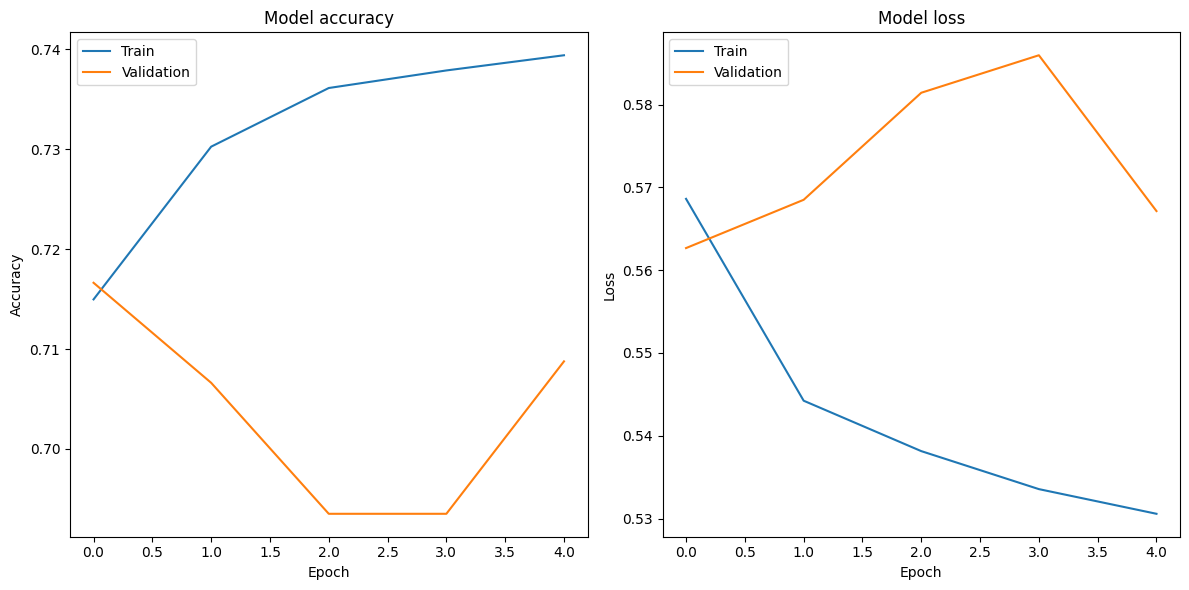

In [ ]:
# Assuming 'history' is the result of fitting your model
# Plot training & validation accuracy values
plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
plt.plot(history_ffnn.history['accuracy'])
plt.plot(history_ffnn.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')

# Plot training & validation loss values
plt.subplot(1, 2, 2)
plt.plot(history_ffnn.history['loss'])
plt.plot(history_ffnn.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')

plt.tight_layout()
plt.show()

In [ ]:
def make_prediction(text):
    # Preprocess the example text
    preprocessed_text = limpiar_tweet(text)

    # Tokenize the preprocessed text
    sequence = tokenizer.texts_to_sequences([preprocessed_text])

    # Pad the sequence
    padded_sequence = pad_sequences(sequence, maxlen=100)

    # Make predictions
    predictions = model_ffnn.predict(padded_sequence)

    return predictions

In [ ]:
# Example text
example_text = "The trailer of GTA VI looks great, I love it!"

# Print the predictions
print(make_prediction(example_text))

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
[[0.9819019]]


In [ ]:
# Example text
example_text = "The trailer of GTA VI looks awful, I hate it!"

# Print the predictions
print(make_prediction(example_text))

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
[[0.336839]]


### 6.2 Word2vec + Modelos Secuenciales (LSTM)

En este bloque entrenaremos un modelo secuencial, en concreto un LSTM, para clasificar los sentimientos de los tweets. La capa de embeddings será inicializada con los embeddings de word2vec.

In [ ]:
# Define LSTM model
model_lstm = Sequential([
    Embedding(len(tokenizer.word_index) + 1, 100, weights=[embedding_matrix], input_length=100, trainable=False),
    LSTM(128),
    Dense(1, activation='sigmoid')
])

# Printear la arquitectura del modelo
model_lstm.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding_1 (Embedding)         │ ?                      │     2,122,400 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm (LSTM)                     │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,122,400 (8.10 MB)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 2,122,400 (8.10 MB)

In [ ]:
# Compilar el modelo
model_lstm.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Ejemplo de entrenamiento del modelo y guardado del historial
history_lstm = model_lstm.fit(X, y, epochs=5, validation_split=0.2)

Epoch 1/5
1049/1049 ━━━━━━━━━━━━━━━━━━━━ 49s 45ms/step - accuracy: 0.7123 - loss: 0.5588 - val_accuracy: 0.7188 - val_loss: 0.5375
Epoch 2/5
1049/1049 ━━━━━━━━━━━━━━━━━━━━ 67s 64ms/step - accuracy: 0.7522 - loss: 0.5007 - val_accuracy: 0.6842 - val_loss: 0.5963
Epoch 3/5
1049/1049 ━━━━━━━━━━━━━━━━━━━━ 77s 73ms/step - accuracy: 0.7647 - loss: 0.4737 - val_accuracy: 0.7220 - val_loss: 0.5686
Epoch 4/5
1049/1049 ━━━━━━━━━━━━━━━━━━━━ 77s 74ms/step - accuracy: 0.7886 - loss: 0.4384 - val_accuracy: 0.6881 - val_loss: 0.6017
Epoch 5/5
1049/1049 ━━━━━━━━━━━━━━━━━━━━ 84s 80ms/step - accuracy: 0.8129 - loss: 0.3937 - val_accuracy: 0.6958 - val_loss: 0.6479


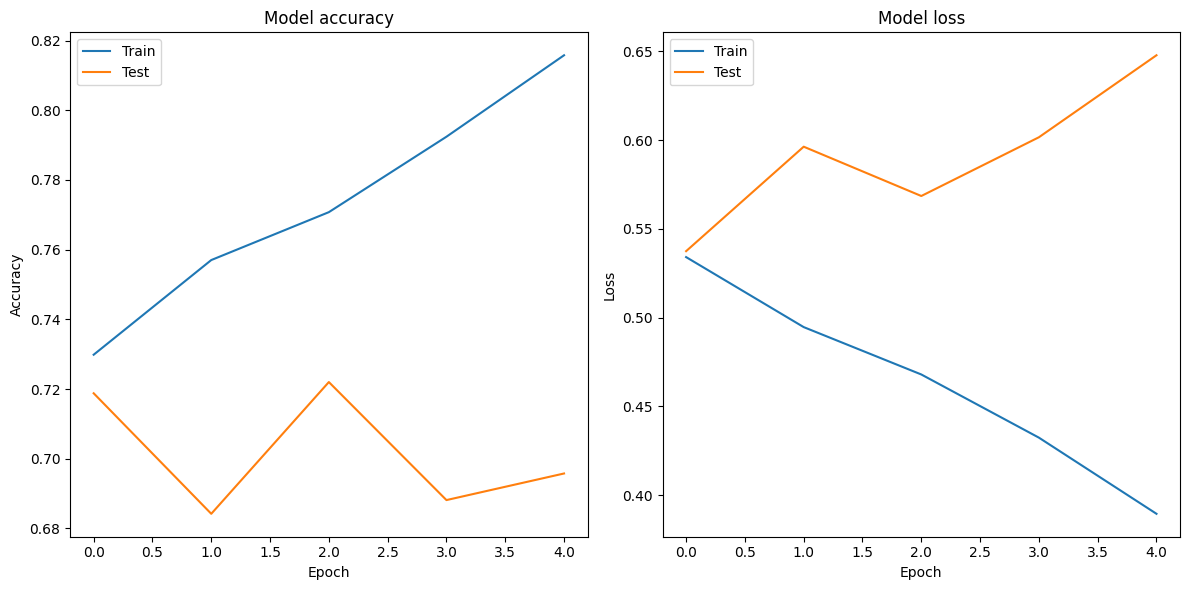

In [ ]:
# Assuming 'history' is the result of fitting your model
# Plot training & validation accuracy values
plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
plt.plot(history_lstm.history['accuracy'])
plt.plot(history_lstm.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')

# Plot training & validation loss values
plt.subplot(1, 2, 2)
plt.plot(history_lstm.history['loss'])
plt.plot(history_lstm.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')

plt.tight_layout()
plt.show()

### 6.3 Modelos Preentrenados (BERT)

En este apartado utilizaremos un modelo preentrenado de BERT para clasificar los sentimientos de los tweets. BERT es un modelo de lenguaje bidireccional que ha sido preentrenado en un gran corpus de texto. Utilizaremos la librería transformers de Hugging Face para cargar el modelo preentrenado y entrenar un clasificador de sentimientos.

In [ ]:
### Entrena tu propio modelo BERT ###

#### 6.3.1 Usamos un modelo preentrenado de BERT

En HugginFace hay varios modelos preentrenados de BERT. En este apartado usaremos un modelo preentrenado de BERT para clasificar los sentimientos de los tweets: https://huggingface.co/cardiffnlp/twitter-roberta-base-sentiment-latest

In [ ]:
from transformers import pipeline

# Cargamos el modelo
MODEL = f"cardiffnlp/twitter-roberta-base-sentiment-latest"
sentiment_task = pipeline("sentiment-analysis", model=MODEL, tokenizer=MODEL)
sentiment_task("Covid cases are increasing fast!")

Some weights of the model checkpoint at cardiffnlp/twitter-roberta-base-sentiment-latest were not used when initializing RobertaForSequenceClassification: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
- This IS expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


[{'label': 'negative', 'score': 0.7235766649246216}]

In [ ]:
sentiment_task("The trailer of GTA VI looks awful, I hate it!")

[{'label': 'negative', 'score': 0.953079342842102}]

### 6.4 Comparar resultados de los dos modelos entrenados (FFNN y LSTM)

En este apartado se compararán los resultados de los dos modelos entrenados: la red neuronal feedforward y el modelo secuencial (LSTM). Se mostrarán las matrices de confusión para cada modelo y se calcularán las métricas de evaluación.

In [ ]:
# Filtrar el dataset para que solo contenga las clases 'Positive' y 'Negative'
df_test = df_test[df_test['label'].isin(['Positive', 'Negative'])]

# Preparamos los datos de test
sequences_test = tokenizer.texts_to_sequences(df_test['text_clean'].values)
X_test = pad_sequences(sequences_test, maxlen=100)
X_test = X_test.astype('float32')
y_test = df_test['label'].map({'Positive': 1, 'Negative': 0}).values.astype('float32')

In [ ]:
# Evaluamos el modelo ffnn en los datos de test
loss_ffnn, accuracy_ffnn = model_ffnn.evaluate(X_test, y_test)

# Evaluamos el modelo lstm en los datos de test
loss_lstm, accuracy_lstm = model_lstm.evaluate(X_test, y_test)

print(f"Accuracy of model_ffnn: {accuracy_ffnn}")
print(f"Accuracy of model_lstm: {accuracy_lstm}")

17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 748us/step - accuracy: 0.7355 - loss: 0.5208
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - accuracy: 0.8280 - loss: 0.3825
Accuracy of model_ffnn: 0.7472324967384338
Accuracy of model_lstm: 0.830258309841156


17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 841us/step
17/17 ━━━━━━━━━━━━━━━━━━━━ 1s 24ms/step


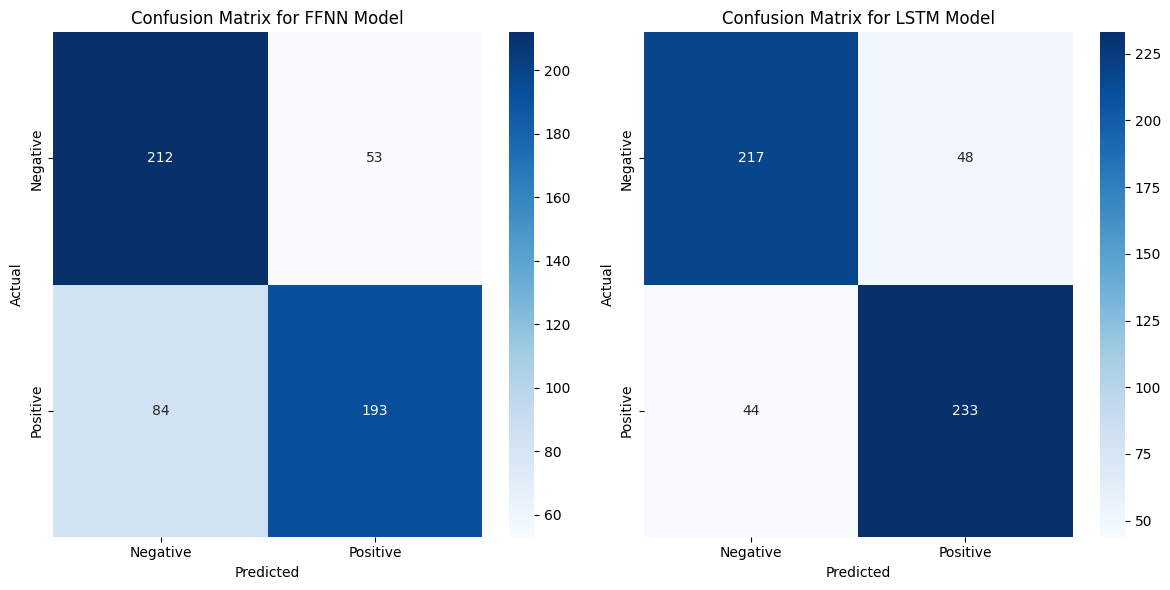

In [ ]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# Get the predictions for model_ffnn
y_pred_ffnn = model_ffnn.predict(X_test)
y_pred_ffnn = (y_pred_ffnn > 0.5).astype(int)

# Get the predictions for model_lstm
y_pred_lstm = model_lstm.predict(X_test)
y_pred_lstm = (y_pred_lstm > 0.5).astype(int)

# Compute the confusion matrix for model_ffnn
cm_ffnn = confusion_matrix(y_test, y_pred_ffnn)

# Compute the confusion matrix for model_lstm
cm_lstm = confusion_matrix(y_test, y_pred_lstm)

# Plot both confusion matrices side by side
plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
sns.heatmap(cm_ffnn, annot=True, fmt='g', cmap='Blues', xticklabels=['Negative', 'Positive'], yticklabels=['Negative', 'Positive'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix for FFNN Model')

plt.subplot(1, 2, 2)
sns.heatmap(cm_lstm, annot=True, fmt='g', cmap='Blues', xticklabels=['Negative', 'Positive'], yticklabels=['Negative', 'Positive'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix for LSTM Model')

plt.tight_layout()

# Qué hemos aprendido hoy?

- Introducción al NLP y casos de uso
- Preprocesamiento de textos
- Word Embeddings
- Modelos Secuenciales
- Modelos Preentrenados